In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import mean_absolute_error,mean_squared_error

In [22]:
#資料準備
url = 'https://raw.githubusercontent.com/oluwole-packt/datasets/main/sales_data.csv'
df = pd.read_csv(url)
df.head()

,Date,Sales
0,2013-01-01,57.00
1,2013-01-02,58.94
2,2013-01-03,45.84
3,2013-01-04,45.97
4,2013-01-05,54.85


In [23]:
#資料處理
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#取出銷售值
data = df['Sales'].values

In [24]:
#window、Xy設定
window = 20
X = []
y = []
for i in range(window,len(data)):
    X.append(data[i-window:i])
    y.append(data[i])
#轉為array
X = np.array(X)
y = np.array(y)
#分割訓練驗證集
train_split = int(len(X)*0.8)
X_train,X_val = X[:train_split],X[train_split:]
y_train,y_val = y[:train_split],y[train_split:]

In [25]:
#參數設定
batch_size = 128
buffer_size = 10000
#轉為tensor
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#cache暫存記憶體優化、experimental.AUTOTUNE自動決定batch_size
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
#模型驗證&畫圖函式
def evaluated(model,X_val,y_val):
    forecast_val = model.predict(X_val)
    forecast_val = np.squeeze(forecast_val)#處理形狀，改成(727,)
    mae_exp = mean_absolute_error(y_val, forecast_val)
    mse_exp = mean_squared_error(y_val, forecast_val)
    return mae_exp, mse_exp, forecast_val


def plot_predict(forecast_val,title = 'Ann model plot',labels='Exponential Decay Predicted',start_date=None, end_date=None):
    plt.plot(forecast_val,label=labels)
    plt.plot(y_val, label='Actual')
    if start_date and end_date:
        start_idx = df.index.get_loc(pd.Timestamp(start_date))
        end_idx = df.index.get_loc(pd.Timestamp(end_date))
        start_idx -= len(data) - len(y_val)
        end_idx -= len(data) - len(y_val)
        plt.xlim(start_idx, end_idx)
    plt.title(title)
    plt.legend()
    plt.show()

In [27]:
#設置基本ANN_MODEL
ann_model = Sequential()
ann_model.add(Dense(10, activation='relu',input_shape=(window,)))
ann_model.add(Dense(10, activation='relu'))
ann_model.add(Dense(1))

In [28]:
#訓練
ann_model.compile(optimizer='adam', loss='mse')
history = ann_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
91/91 [==============================] - 0s 2ms/step - loss: 3840.3022
Epoch 2/100
91/91 [==============================] - 0s 2ms/step - loss: 89.8266
Epoch 3/100
91/91 [==============================] - 0s 1ms/step - loss: 51.3326
Epoch 4/100
91/91 [==============================] - 0s 1ms/step - loss: 50.5616
Epoch 5/100
91/91 [==============================] - 0s 1ms/step - loss: 49.9973
Epoch 6/100
91/91 [==============================] - 0s 1ms/step - loss: 49.4657
Epoch 7/100
91/91 [==============================] - 0s 1ms/step - loss: 49.3628
Epoch 8/100
91/91 [==============================] - 0s 1ms/step - loss: 48.8296
Epoch 9/100
91/91 [==============================] - 0s 1ms/step - loss: 48.5989
Epoch 10/100
91/91 [==============================] - 0s 1ms/step - loss: 48.3126
Epoch 11/100
91/91 [==============================] - 0s 1ms/step - loss: 48.2459
Epoch 12/100
91/91 [==============================] - 0s 1ms/step - loss: 47.2560
Epoch 13/100
91/91 [===

23/23 [==============================] - 0s 1ms/step
MAE: 4.653186798095703, MSE: 33.70686340332031


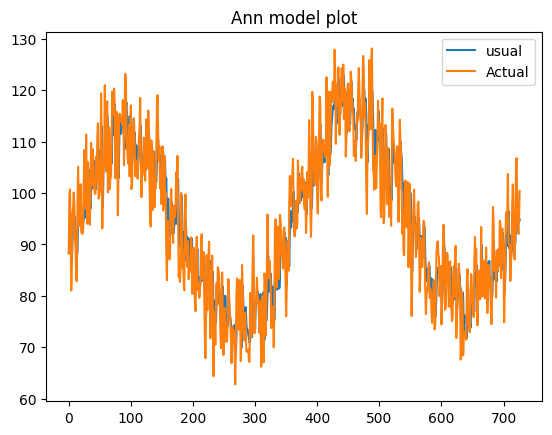

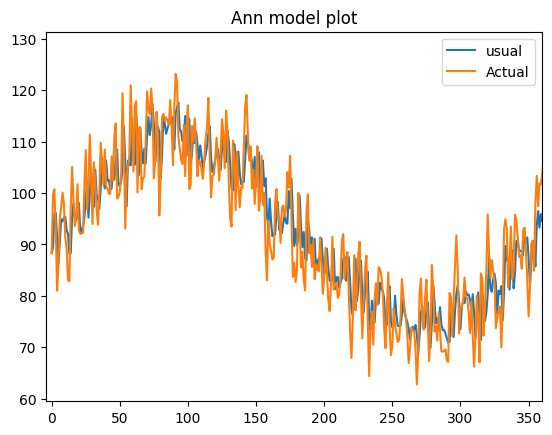

In [29]:
#ANN_MODEL驗證&畫圖
mae, mse,forecast_val = evaluated(ann_model,X_val,y_val)
print(f'MAE: {mae}, MSE: {mse}')
plot_predict(forecast_val,title = 'Ann model plot',labels='usual')
plot_predict(forecast_val,title = 'Ann model plot',labels='usual',start_date='2021-01-01',end_date='2021-12-31')

In [46]:
##測試其他lr
lr_schedules = {
    'Exponential Decay': tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,decay_steps=100, decay_rate=0.96),
    'Piecewise Constant': tf.keras.optimizers.schedules.PiecewiseConstantDecay([30, 60], [0.1, 0.01, 0.001]),
    'Polynomial Decay': tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.1, decay_steps=100, end_learning_rate=0.01, power=1.0)
}

23/23 [==============================] - 0s 554us/step
MAE: 4.500056266784668, MSE: 31.30975341796875
23/23 [==============================] - 0s 507us/step
MAE: 4.458844184875488, MSE: 30.649425506591797
23/23 [==============================] - 0s 539us/step
MAE: 4.428442478179932, MSE: 30.293865203857422


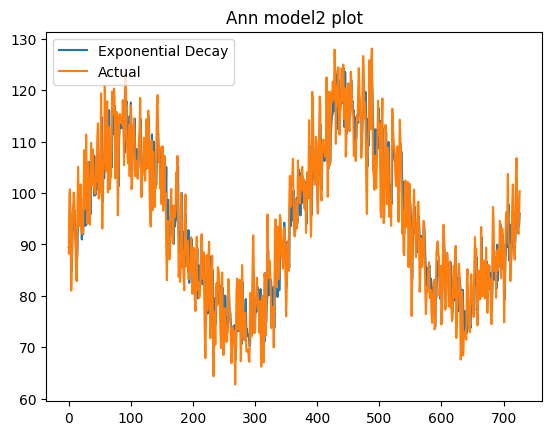

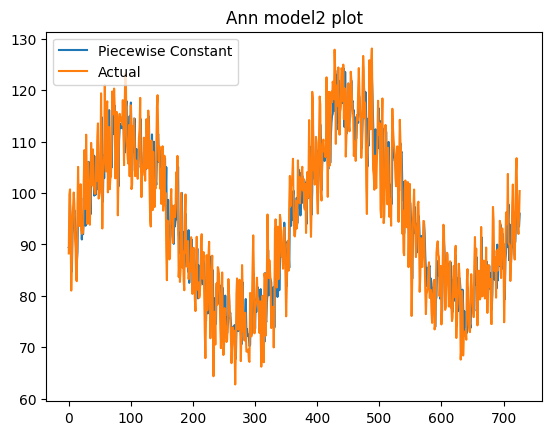

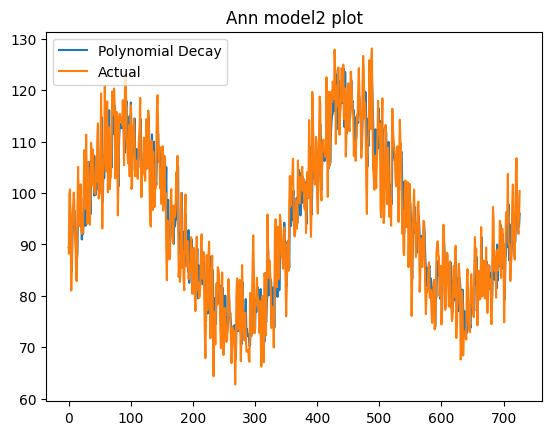

In [53]:
#設置ann_model2
ann_model2 = Sequential()
ann_model2.add(Dense(10, activation='relu',input_shape=(window,)))
ann_model2.add(Dense(10, activation='relu'))
ann_model2.add(Dense(1))
#LR 設定
#儲存forecast_val
forecasts = {}
for i,lr_exp in lr_schedules.items():
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_exp)
    #訓練
    ann_model2.compile(optimizer=optimizer, loss='mse')
    ann_model2.fit(X_train, y_train, epochs=100,verbose = 0)
    mae, mse, forecast_val= evaluated(ann_model2,X_val,y_val)
    forecasts[i] = forecast_val
    print(f'MAE: {mae}, MSE: {mse}')

for i,forecast in forecasts.items():
    plot_predict(forecast_val,title = 'Ann model2 plot',labels=i)

In [30]:
##CNN模型
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Flatten

In [31]:
#window、Xy設定
window = 20
X = []
y = []
for i in range(window,len(data)):
    X.append(data[i-window:i])
    y.append(data[i])
#轉為array
X = np.array(X)
y = np.array(y)
#分割訓練驗證集
train_split = int(len(X)*0.8)
X_train,X_val = X[:train_split],X[train_split:]
y_train,y_val = y[:train_split],y[train_split:]

In [32]:
# 為符合CNN要求，重設X形狀
X1_train = X_train.reshape(-1, window, 1)
X1_val = X_val.reshape(-1, window, 1)
train_data = tf.data.Dataset.from_tensor_slices((X1_train, y_train))
train_data = train_data.shuffle(buffer_size).batch(batch_size)

#CNN模型設置
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=(window, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=32, kernel_size=3))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dense(1))

In [81]:
re = cnn_model.predict(X_val)
print(re.shape)

23/23 [==============================] - 0s 2ms/step
(727, 1)


In [33]:
#進行訓練
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.fit(train_data, epochs=100)

Epoch 1/100
23/23 [==============================] - 1s 6ms/step - loss: 1831.2567
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 122.4643
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 49.9247
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 45.8241
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 44.8759
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 44.7599
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 44.7558
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 44.4442
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 44.3777
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 44.0221
Epoch 11/100
23/23 [==============================] - 0s 2ms/step - loss: 43.8916
Epoch 12/100
23/23 [==============================] - 0s 2ms/step - loss: 43.7009
Epoch 13/100
23/23 [==

23/23 [==============================] - 0s 3ms/step
MAE: 4.997991561889648, MSE: 38.56024932861328


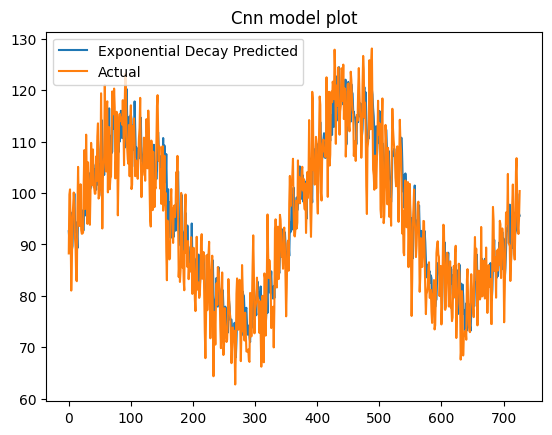

In [64]:
#指標驗證
mae,mse,forecast_val = evaluated(cnn_model,X_val,y_val)
print(f'MAE: {mae}, MSE: {mse}')
plot_predict(forecast_val,title = 'Cnn model plot')

In [37]:
##RNN模型
from tensorflow.keras.layers import SimpleRNN,Lambda

In [38]:
#window、Xy設定
window = 20
X = []
y = []
for i in range(window,len(data)):
    X.append(data[i-window:i])
    y.append(data[i])
#轉為array
X = np.array(X)
y = np.array(y)
#分割訓練驗證集
train_split = int(len(X)*0.8)
X_train,X_val = X[:train_split],X[train_split:]
y_train,y_val = y[:train_split],y[train_split:]

In [39]:
# 為符合RNN要求，重設X形狀
X1_train = X_train.reshape(-1, window, 1)
X1_val = X_val.reshape(-1, window, 1)
train_data = tf.data.Dataset.from_tensor_slices((X1_train, y_train))
train_data = train_data.shuffle(buffer_size).batch(batch_size)
#模型設置
rnn_model = Sequential([
            SimpleRNN(40,return_sequences=True),
            SimpleRNN(40),
            Dense(1),
            Lambda(lambda x: x * 100.0)])

In [40]:
#進行訓練
rnn_model.compile(loss='mse', optimizer='adam')
rnn_model.fit(train_data, epochs=100)

Epoch 1/100
23/23 [==============================] - 1s 19ms/step - loss: 4362.4312
Epoch 2/100
23/23 [==============================] - 0s 16ms/step - loss: 376.3555
Epoch 3/100
23/23 [==============================] - 0s 15ms/step - loss: 118.0782
Epoch 4/100
23/23 [==============================] - 0s 16ms/step - loss: 60.5986
Epoch 5/100
23/23 [==============================] - 0s 15ms/step - loss: 52.0103
Epoch 6/100
23/23 [==============================] - 0s 15ms/step - loss: 48.5109
Epoch 7/100
23/23 [==============================] - 0s 16ms/step - loss: 46.3847
Epoch 8/100
23/23 [==============================] - 0s 16ms/step - loss: 43.6828
Epoch 9/100
23/23 [==============================] - 0s 17ms/step - loss: 42.2081
Epoch 10/100
23/23 [==============================] - 0s 15ms/step - loss: 40.7100
Epoch 11/100
23/23 [==============================] - 0s 17ms/step - loss: 39.8734
Epoch 12/100
23/23 [==============================] - 0s 17ms/step - loss: 39.0436
Epoch 13/

23/23 [==============================] - 0s 6ms/step
MAE: 4.793550491333008, MSE: 36.12279510498047


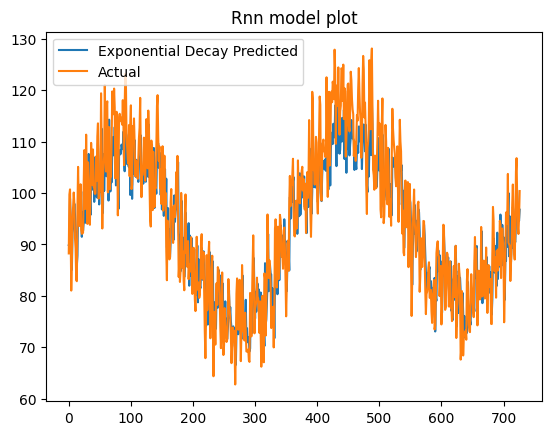

In [41]:
#指標驗證
mae,mse,forecast_val = evaluated(rnn_model,X_val,y_val)
print(f'MAE: {mae}, MSE: {mse}')
plot_predict(forecast_val,title = 'Rnn model plot')

In [49]:
##LSTM模型
from tensorflow.keras.layers import LSTM

In [59]:
#window、Xy設定
window = 20
X = []
y = []
for i in range(window,len(data)):
    X.append(data[i-window:i])
    y.append(data[i])
#轉為array
X = np.array(X)
y = np.array(y)
#分割訓練驗證集
train_split = int(len(X)*0.8)
X_train,X_val = X[:train_split],X[train_split:]
y_train,y_val = y[:train_split],y[train_split:]

In [61]:
# 為符合LSTM要求，重設X形狀
X1_train = X_train.reshape(-1, window, 1)
X1_val = X_val.reshape(-1, window, 1)
train_data = tf.data.Dataset.from_tensor_slices((X1_train, y_train))
train_data = train_data.shuffle(buffer_size).batch(batch_size)
#模型設置
lstm_model = Sequential([
            LSTM(40,return_sequences=True,input_shape=[None,1]),
            tf.keras.layers.LSTM(50),
            tf.keras.layers.Dense(30),
            tf.keras.layers.Dense(1)])

In [62]:
#進行訓練
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(train_data, epochs=800,verbose=0)

23/23 [==============================] - 0s 1ms/step
MAE: 5.190204620361328, MSE: 42.384010314941406


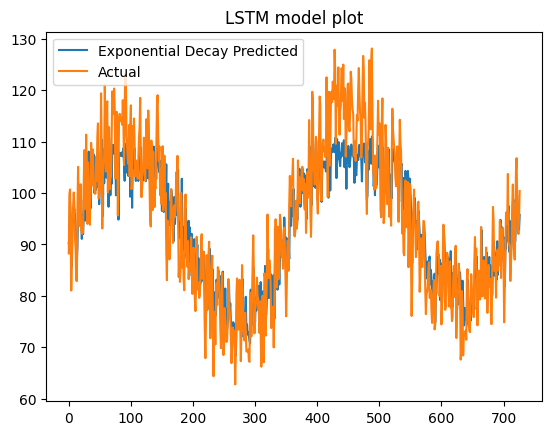

In [63]:
#指標驗證
mae,mse,forecast_val = evaluated(lstm_model,X_val,y_val)
print(f'MAE: {mae}, MSE: {mse}')
plot_predict(forecast_val,title = 'LSTM model plot')

In [ ]:
##CNN-LSTM

In [120]:
#window、Xy設定
window = 20
X = []
y = []
for i in range(window,len(data)):
    X.append(data[i-window:i])
    y.append(data[i])
#轉為array
X = np.array(X)
y = np.array(y)
#分割訓練驗證集
train_split = int(len(X)*0.8)
X_train,X_val = X[:train_split],X[train_split:]
y_train,y_val = y[:train_split],y[train_split:]

In [124]:
# 為符合CNN-LSTM要求，重設X形狀
X1_train = X_train.reshape(-1, window, 1)
X1_val = X_val.reshape(-1, window, 1)
train_data = tf.data.Dataset.from_tensor_slices((X1_train, y_train))
train_data = train_data.shuffle(buffer_size).batch(batch_size)
#模型設置
cnnlstm_model = Sequential()
cnnlstm_model.add(Conv1D(filters=128, kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window,1]))
cnnlstm_model.add(LSTM(128, return_sequences=True))
cnnlstm_model.add(LSTM(128))
cnnlstm_model.add(Dense(64, activation="relu"))
cnnlstm_model.add(Dense(30, activation="relu"))
cnnlstm_model.add(Dense(10, activation="relu"))
cnnlstm_model.add(Dense(1))

In [125]:
#進行訓練
cnnlstm_model.compile(loss='mse', optimizer='adam')
cnnlstm_model.fit(train_data, epochs=450,verbose=0)

23/23 [==============================] - 0s 2ms/step
MAE: 5.085489749908447, MSE: 39.86267852783203


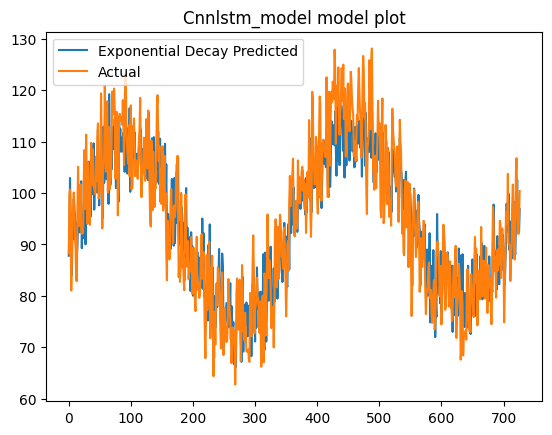

In [126]:
#指標驗證
mae,mse,forecast_val = evaluated(cnnlstm_model,X_val,y_val)
print(f'MAE: {mae}, MSE: {mse}')
plot_predict(forecast_val,title = 'Cnnlstm_model model plot')

In [ ]:
##CNN-LSTM2

In [104]:
#window、Xy設定
window = 20
X = []
y = []
for i in range(window,len(data)):
    X.append(data[i-window:i])
    y.append(data[i])
#轉為array
X = np.array(X)
y = np.array(y)
#分割訓練驗證集
train_split = int(len(X)*0.8)
X_train,X_val = X[:train_split],X[train_split:]
y_train,y_val = y[:train_split],y[train_split:]

In [105]:
X1_train = X_train.reshape(-1, window, 1)
X1_val = X_val.reshape(-1, window, 1)
train_data = tf.data.Dataset.from_tensor_slices((X1_train, y_train))
train_data = train_data.shuffle(buffer_size).batch(batch_size)
#模型設置
cnnlstm_model2 = Sequential()
cnnlstm_model2.add(Conv1D(filters=64, kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window,1]))
cnnlstm_model2.add(SimpleRNN(64,return_sequences=True))
cnnlstm_model2.add(LSTM(64, return_sequences=True))
cnnlstm_model2.add(LSTM(64))
cnnlstm_model2.add(Dense(30, activation="relu"))
cnnlstm_model2.add(Dense(10, activation="relu"))
cnnlstm_model2.add(Dense(1))

In [106]:
#進行訓練
cnnlstm_model2.compile(loss='mse', optimizer='adam')
cnnlstm_model.fit(train_data, epochs=200,verbose=0)

23/23 [==============================] - 0s 1ms/step
MAE: 6.4763503074646, MSE: 64.59825134277344


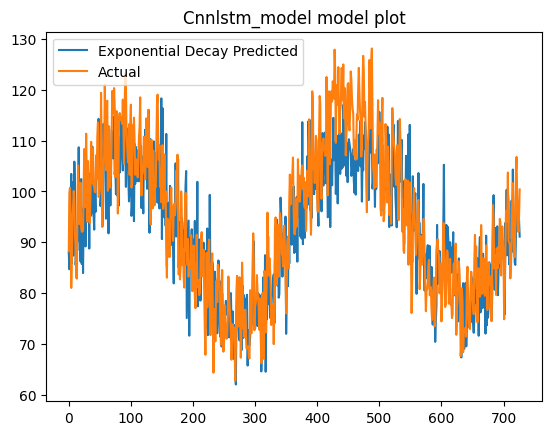

In [107]:
#指標驗證
mae,mse,forecast_val = evaluated(cnnlstm_model,X_val,y_val)
print(f'MAE: {mae}, MSE: {mse}')
plot_predict(forecast_val,title = 'Cnnlstm_model model plot')